# Setting up the environment

In this section, we import all the necessary libraries that will be used in this notebook. These include libraries for data manipulation, machine learning model creation, evaluation, and visualization.

In [1]:
# Import necessary libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib  # For loading the saved model
import json

In [2]:
# Start tracking time for performance evaluation
start_time = time.time()

# Load Pre-Trained Model and Selected Features

The model and selected features are loaded from files in the `Models` folder.

In [3]:
model_file = 'Models/PD_n1_c5_delta_xb30.joblib'
features_file = 'Models/PD_n1_c5_delta_xb30.json'

In [4]:
# Load pre-trained model
if not os.path.exists(model_file):
    raise FileNotFoundError(f"Model file {model_file} not found.")
model = joblib.load(model_file)

In [5]:
# Load selected features
if not os.path.exists(features_file):
    raise FileNotFoundError(f"Features file {features_file} not found.")
with open(features_file, 'r') as f:
    selected_features = json.load(f)['features']

# Dataset Configuration

Set paths to input files.

In [6]:
dataset_name = 'PD'
reduction_method = '_n1_c5_delta'
input_file = os.path.join('Input', f'{dataset_name}{reduction_method}.csv')
output_file = f'{dataset_name}{reduction_method}_xb30'

In [7]:
# Load data from CSV, raising an error if file is missing
if not os.path.exists(input_file):
    raise FileNotFoundError(f"Input file {input_file} not found.")
df = pd.read_csv(input_file)

# Feature Engineering

This function adds new features such as sine/cosine transformations for the 'week' column and growth rates for vegetation indices.

In [8]:
def add_features(df):
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['growth_rate_ndvi'] = df['veg_max_ndvi'] - df['veg_min_ndvi']
    df['growth_rate_evi'] = df['veg_max_evi'] - df['veg_min_evi']
    df['growth_rate_lai'] = df['veg_max_lai'] - df['veg_min_lai']
    df['mean_combined_vegetation_index'] = (df['veg_mean_evi'] + df['veg_mean_ndvi'] + df['veg_mean_lai']) / 3
    return df

In [9]:
# Apply feature engineering
df = add_features(df)

# Using Full Dataset for Model Evaluation

Fit the model on the entire dataset and calculate metrics without splitting the data.

In [10]:
X = df[selected_features]
y = df["Mean"]

# Using the full dataset for training and evaluation
model.fit(X, y)
y_pred = model.predict(X)

# Calculate Metrics

Define a function to calculate model performance metrics including RMSE, R², and MAE.

In [11]:
def calculate_metrics(y_true, y_pred, X=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    aic = None
    if X is not None:
        aic = 2 * len(X.columns) + len(X) * np.log(rmse ** 2)  # Optional AIC Calculation
    return rmse, r2, mae, aic

In [12]:
# Calculate metrics for the full dataset
rmse, r2, mae, _ = calculate_metrics(y, model.predict(X), X)

# Plotting Feature Importance

We plot the feature importance of the final model using the features selected during the previous training process.

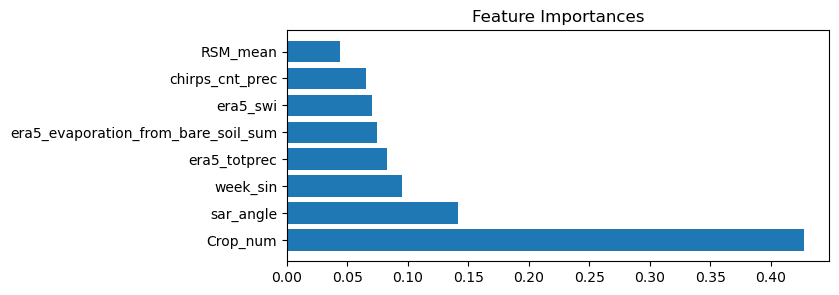

In [13]:
def plot_feature_importance(model, X, output_file):
    fig, ax = plt.subplots(figsize=(7, 3))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    ax.barh(range(X.shape[1]), importances[indices])
    ax.set_yticks(range(X.shape[1]))
    ax.set_yticklabels(X.columns[indices])
    ax.set_title(f"Feature Importances")
    plt.show()

# Call feature importance plot function
plot_feature_importance(model, X, output_file)

# Save Results DataFrame

Create and save a DataFrame that includes observed and predicted yields, along with crop type, field ID, year, and week.

In [14]:
def create_results_df(X, y, model):
    return pd.DataFrame({
        'Yield_mean': y,
        'Predicted_Yield': model.predict(X),
        'Crop_type': df['Crop_type'].reset_index(drop=True),
        'FIELDID': df['FIELDID'].reset_index(drop=True),
        'Year': df['Year'].reset_index(drop=True),
        'Week': df['week'].reset_index(drop=True),
        'Data_Type': ['Full'] * len(y)
    })

In [15]:
# Create results DataFrame
results_df = create_results_df(X, y, model)

# Plot Time Series Scatter for Maize and Soy

Generate time series scatter plots for Maize and Soy data showing observed vs. predicted yields over time.

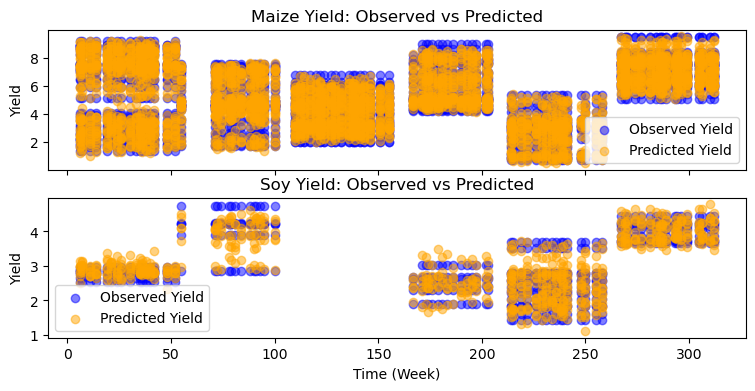

In [16]:
def plot_time_series_scatter(results_df, output_file):
    # Filtering for Maize and Soy data
    maize_df = results_df[results_df['Crop_type'] == 'Maize']
    soy_df = results_df[results_df['Crop_type'] == 'Soy']

    # Sorting by Year and Week to avoid zig-zag connections
    maize_df = maize_df.sort_values(by=['Year', 'Week'])
    soy_df = soy_df.sort_values(by=['Year', 'Week'])

    # Create a continuous time axis for Maize and Soy
    maize_time = maize_df['Week'] + (maize_df['Year'] - maize_df['Year'].min()) * 52
    soy_time = soy_df['Week'] + (soy_df['Year'] - soy_df['Year'].min()) * 52

    # Plotting Time Series for Maize and Soy
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 4), sharex=True)

    # Maize Time Series Plot (Scatter)
    axes[0].scatter(maize_time, maize_df['Yield_mean'], label='Observed Yield', color='blue', alpha=0.5)
    axes[0].scatter(maize_time, maize_df['Predicted_Yield'], label='Predicted Yield', color='orange', alpha=0.5)
    axes[0].set_title('Maize Yield: Observed vs Predicted')
    axes[0].set_ylabel('Yield')
    axes[0].legend()

    # Soy Time Series Plot (Scatter)
    axes[1].scatter(soy_time, soy_df['Yield_mean'], label='Observed Yield', color='blue', alpha=0.5)
    axes[1].scatter(soy_time, soy_df['Predicted_Yield'], label='Predicted Yield', color='orange', alpha=0.5)
    axes[1].set_title('Soy Yield: Observed vs Predicted')
    axes[1].set_xlabel('Time (Week)')
    axes[1].set_ylabel('Yield')
    axes[1].legend()

# Call time series scatter plot function
plot_time_series_scatter(results_df, output_file)

# Plot Time Series Scatter for Selected Fields (Maize and Soy)

Generate time series scatter plots for selected Maize and Soy fields showing observed vs. predicted yields.

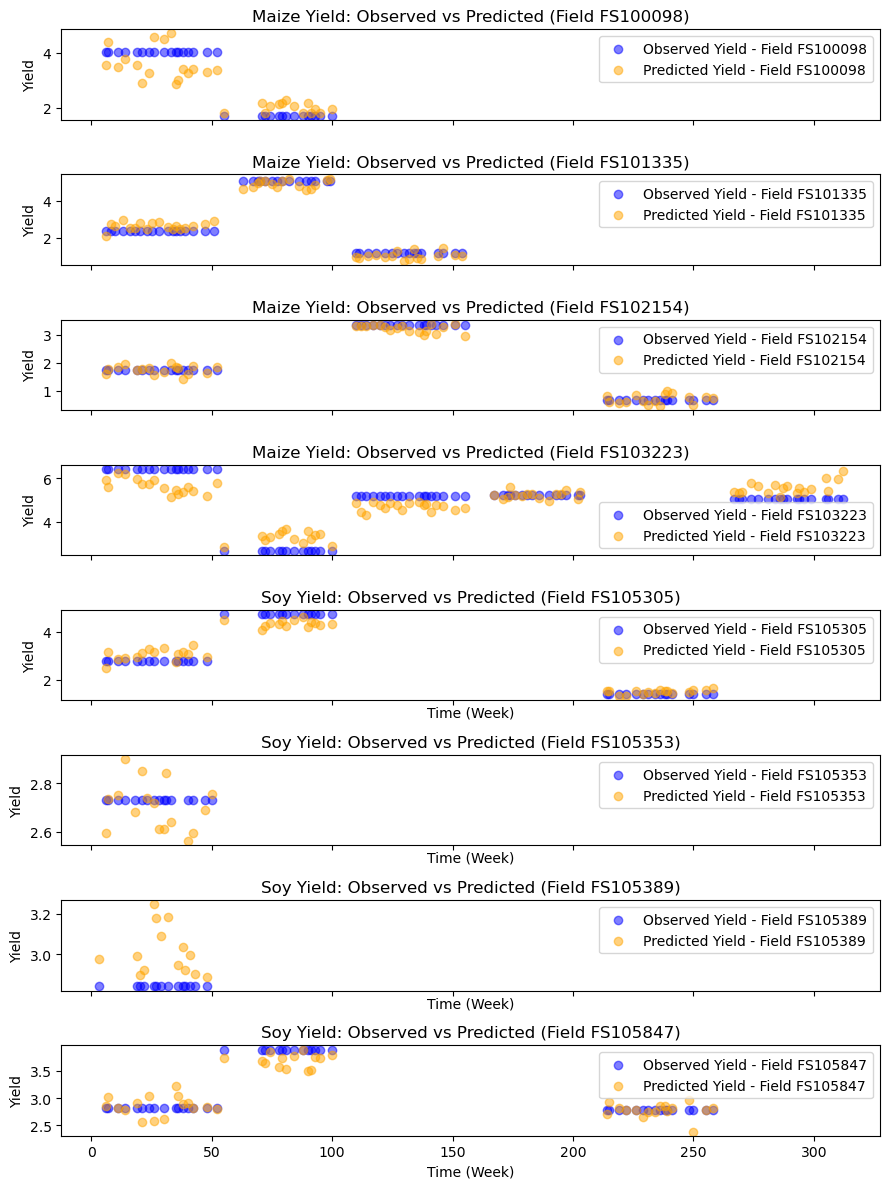

In [17]:
def plot_selected_fields(results_df, selected_maize_fields, selected_soy_fields, output_file):
    maize_df = results_df[results_df['Crop_type'] == 'Maize']
    soy_df = results_df[results_df['Crop_type'] == 'Soy']

    # Sorting the fields by FIELDID for both Maize and Soy
    maize_fields = sorted(maize_df['FIELDID'].unique())
    soy_fields = sorted(soy_df['FIELDID'].unique())

    # Validate the selected fields
    valid_maize_fields = [maize_fields[field - 1] for field in selected_maize_fields if field <= len(maize_fields)]
    valid_soy_fields = [soy_fields[field - 1] for field in selected_soy_fields if field <= len(soy_fields)]

    if not valid_maize_fields or not valid_soy_fields:
        print(f"Error: The requested field index is out of bounds. Maize fields available: {len(maize_fields)}, Soy fields available: {len(soy_fields)}")
        return

    # Define the number of rows in the plot grid based on the number of selected fields
    total_plots = len(valid_maize_fields) + len(valid_soy_fields)
    fig, axes = plt.subplots(nrows=total_plots, ncols=1, figsize=(9, 1.5 * total_plots), sharex=True)

    # Plot for each selected Maize field
    for i, selected_maize_field in enumerate(valid_maize_fields):
        maize_df_selected = maize_df[maize_df['FIELDID'] == selected_maize_field]
        maize_df_selected = maize_df_selected.sort_values(by=['Year', 'Week'])
        maize_time = maize_df_selected['Week'] + (maize_df_selected['Year'] - maize_df_selected['Year'].min()) * 52
        axes[i].scatter(maize_time, maize_df_selected['Yield_mean'], label=f'Observed Yield - Field {selected_maize_field}', color='blue', alpha=0.5)
        axes[i].scatter(maize_time, maize_df_selected['Predicted_Yield'], label=f'Predicted Yield - Field {selected_maize_field}', color='orange', alpha=0.5)
        axes[i].set_title(f'Maize Yield: Observed vs Predicted (Field {selected_maize_field})')
        axes[i].set_ylabel('Yield')
        axes[i].legend()

    # Plot for each selected Soy field
    for j, selected_soy_field in enumerate(valid_soy_fields):
        soy_df_selected = soy_df[soy_df['FIELDID'] == selected_soy_field]
        soy_df_selected = soy_df_selected.sort_values(by=['Year', 'Week'])
        soy_time = soy_df_selected['Week'] + (soy_df_selected['Year'] - soy_df_selected['Year'].min()) * 52
        axes[len(valid_maize_fields) + j].scatter(soy_time, soy_df_selected['Yield_mean'], label=f'Observed Yield - Field {selected_soy_field}', color='blue', alpha=0.5)
        axes[len(valid_maize_fields) + j].scatter(soy_time, soy_df_selected['Predicted_Yield'], label=f'Predicted Yield - Field {selected_soy_field}', color='orange', alpha=0.5)
        axes[len(valid_maize_fields) + j].set_title(f'Soy Yield: Observed vs Predicted (Field {selected_soy_field})')
        axes[len(valid_maize_fields) + j].set_xlabel('Time (Week)')
        axes[len(valid_maize_fields) + j].set_ylabel('Yield')
        axes[len(valid_maize_fields) + j].legend()

    # Adjust layout and save the figure
    plt.tight_layout()

# Call plot for selected fields
selected_maize_fields = [1, 2, 3, 4]  # Change this to select specific Maize fields
selected_soy_fields = [1, 2, 3, 4]    # Change this to select specific Soy fields
plot_selected_fields(results_df, selected_maize_fields, selected_soy_fields, output_file)

# Execution Time

Print the total time taken for the script to execute.

In [18]:
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 1.8467159271240234 seconds
